# 03 Propensity Score Matching (PSM)
This notebook implements the Phase 2 PSM pipeline spanning MVP 2.1–2.3:
- MVP 2.1: Propensity score (PS) estimation and distributional diagnostics (Sections 0–1)
- MVP 2.2: PSM (propensity score matching) and covariate balance checks (Sections 2–3)
- MVP 2.3: ATE estimation and consistency checks against an RCT benchmark (Sections 4–5)


## Section 0: Setup

In [37]:
# ======================================================
# Section 0 (Cell 1/1): Setup
# ======================================================
# Complexity: O(n) for loading + slicing (vectorized Pandas).

# ----------------------------------------------------
# 0) Standard imports
# ----------------------------------------------------
import os
import sys
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from IPython.display import Markdown, display

# Explicit timezone anchoring improves reproducibility and auditability across environments.
TZ_UTC8 = timezone(timedelta(hours=8))
run_ts_utc8 = datetime.now(TZ_UTC8).strftime('%Y-%m-%d %H:%M:%S %z')

# Avoid hardcoding the project root path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
# Add project root to sys.path to enable 'from src.xxx import' syntax.
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Change working directory to project root for consistent path resolution
os.chdir(project_root)

from src.causal import estimate_ps

# Standardized plotting style
# Improves visual consistency and reviewer readability.
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

# ----------------------------------------------------
# 1) Load config and setup paths
# ----------------------------------------------------
config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f'No config file found. Searched: {[str(p) for p in config_candidates]}')
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

features_path = Path(config['paths']['features_data'])
assert features_path.exists(), f'Feature file not found: {features_path}'

# Output directory setup (centralized in Setup section for reuse across all sections)
figures_dir = Path(config['paths'].get('figures_dir', 'outputs/figures/'))
figures_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------------------------------
# 2) Load features and extract X, T, Y
# ----------------------------------------------------
df = pd.read_csv(features_path)
assert isinstance(df, pd.DataFrame) and len(df) > 0, 'Loaded features DataFrame is empty'

treatment_col = config['data']['treatment_col']
outcome_col = config['data']['outcome_col']
spend_col = config['data']['spend_col']

assert treatment_col in df.columns, f'Missing required column: {treatment_col}'
assert outcome_col in df.columns, f'Missing required column: {outcome_col}'
assert spend_col in df.columns, f'Missing required column: {spend_col}'

# -----------------------------------------------------
# 3) Use covariates from config.yml to avoid Dummy Variable Trap
# -----------------------------------------------------
# (CRITICAL) Why exclude channel_Multichannel and zip_Rural:
#   1. Perfect multicollinearity: channel_Multichannel = 1 - channel_Phone - channel_Web
#   2. This causes X^T X to be singular (non-invertible)
#   3. Logistic Regression cannot solve for unique coefficients
#   4. Reference categories: Multichannel (for channel), Rural (for zip_code)
# ------------------------------------------------------
covariates = config['data']['covariates']
X = df[covariates].copy()
T = df[treatment_col]
Y = df[outcome_col]

assert len(X) == len(T) == len(Y), 'X/T/Y length mismatch'
assert not X.isnull().any().any(), 'X contains NaN; check feature pipeline'
assert all(pd.api.types.is_numeric_dtype(X[c]) for c in X.columns), 'X must be numeric'
assert np.isfinite(X.to_numpy(dtype=float, copy=False)).all(), 'X contains inf or -inf'

# ----------------------------------------------------
# 4) Summary output
# ----------------------------------------------------
print(f'[UTC+8] Run timestamp: {run_ts_utc8}')
print(f'Loaded: {features_path}')
print(f'df.shape={df.shape} | X.shape={X.shape} | T.mean={float(pd.to_numeric(T, errors="coerce").mean()):.4f} | Y.mean={float(pd.to_numeric(Y, errors="coerce").mean()):.4%}')
print(f'Covariates (n={len(covariates)}): {covariates}')
print(f'Figures will be saved to: {figures_dir}')


[UTC+8] Run timestamp: 2026-02-23 14:30:31 +0800
Loaded: data\processed\hillstrom_features.csv
df.shape=(64000, 16) | X.shape=(64000, 9) | T.mean=0.6671 | Y.mean=0.9031%
Covariates (n=9): ['recency', 'history', 'mens', 'womens', 'newbie', 'channel_Phone', 'channel_Web', 'zip_Surburban', 'zip_Urban']
Figures will be saved to: outputs\figures


## Section 1: Propensity Score (PS) Estimation & Distribution


In [38]:
# ======================================================
# Section 1 (Cell 1/3): PS Estimation
# ======================================================
# Complexity: O(n) inference + vectorized summary statistics.

try:
    ps, model = estimate_ps(X, T, random_state=42)
    ps_s = pd.Series(ps, name='ps')
    display(ps_s.describe())

    # Business-critical RCT validation (technical checks already done in estimate_ps())
    assert 0.60 <= float(ps.mean()) <= 0.72, 'PS mean deviates from treatment ratio; check feature matrix'
    assert float(ps.std()) < 0.10, 'PS std too large; RCT data should not be strongly predictable'

    print(f'model.n_iter_={getattr(model, "n_iter_", None)}')
    print(f'ps.mean={ps.mean():.6f} | ps.std={ps.std():.6f}')
except Exception as exc:
    raise RuntimeError(f'Section 1 PS estimation failed: {exc}') from exc


count    64000.000000
mean         0.667096
std          0.003945
min          0.655530
25%          0.664425
50%          0.666768
75%          0.669423
max          0.699496
Name: ps, dtype: float64

model.n_iter_=[146]
ps.mean=0.667096 | ps.std=0.003945


.png already saved: outputs\figures\fig_02_ps_distribution.png


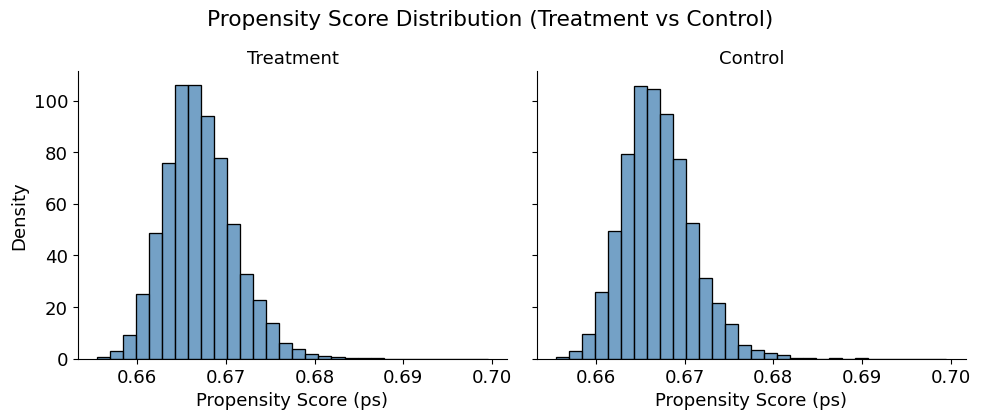

In [39]:
# ======================================================
# Section 1 (Cell 2/3): PS histogram (Treatment vs Control facets)
# ======================================================
# Visualize (histogram) propensity scores (ps) for each treatment group (faceted).
# Complexity: O(n) for vectorized binning + rendering.

try:
    # figures_dir already initialized in Section 0
    
    plot_df = pd.DataFrame({
        'ps': ps,
        'treatment': pd.to_numeric(T, errors='coerce').astype(int).to_numpy(),
    })
    assert plot_df['treatment'].isin([0, 1]).all(), 'Treatment must be binary 0/1 for faceting'
    plot_df['group'] = np.where(plot_df['treatment'] == 1, 'Treatment', 'Control')

    g = sns.displot(
        data=plot_df,
        x='ps',
        col='group',         # Facet by treatment/control
        col_order=['Treatment', 'Control'],
        bins=30,
        stat='density',
        common_bins=True,    # Use same bins for both treatment and control (for compare)
        common_norm=False,
        height=4.0,
        aspect=1.25,
        color='steelblue',
    )
    g.set_axis_labels('Propensity Score (ps)', 'Density')
    g.set_titles('{col_name}')
    # Use figure.suptitle() for FacetGrid overall title (FacetGrid has no .set_title() method)
    g.fig.suptitle('Propensity Score Distribution (Treatment vs Control)', y=1.05)

    out1 = figures_dir / 'fig_02_ps_distribution.png'
    g.fig.savefig(out1, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out1}')
    plt.show()
except Exception as exc:
    raise RuntimeError(f'Section 1 histogram failed: {exc}') from exc

.png already saved: outputs\figures\fig_02b_ps_overlap.png


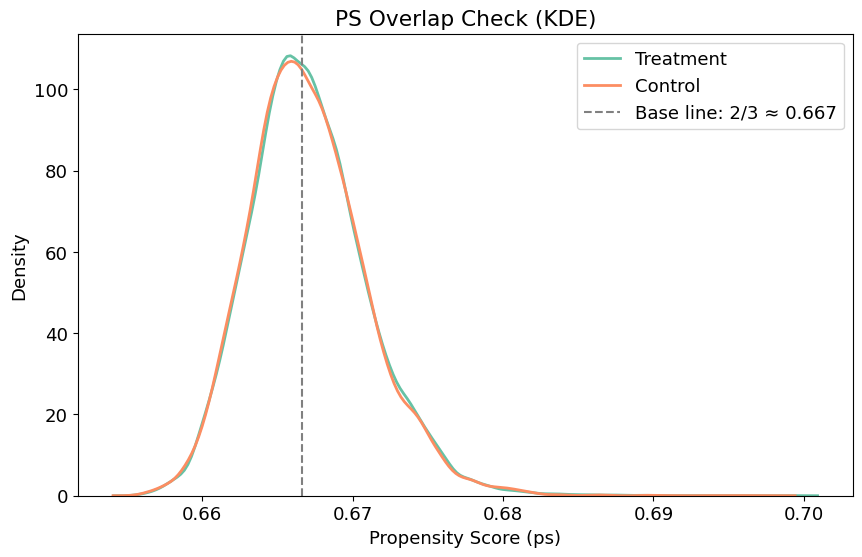

In [40]:
# ======================================================
# Section 1 (Cell 3/4): PS overlap check (KDE overlay)
# ======================================================
# Complexity: KDE is typically O(n)~O(n log n) depending on backend; acceptable for ~64K.

try:
    plt.figure(figsize=(10, 6))

    sns.kdeplot(
        data=plot_df.loc[plot_df['treatment'] == 1],
        x='ps',
        label='Treatment',
        linewidth=2,
    )
    sns.kdeplot(
        data=plot_df.loc[plot_df['treatment'] == 0],
        x='ps',
        label='Control',
        linewidth=2,
    )

    # Add a vertical line at 2/3 to highlight the overlap
    # 2/3: Treatment:Control = 2:1 (2/3 of the population is treated)
    plt.axvline(2 / 3, color='gray', linestyle='--', linewidth=1.5, label='Base line: 2/3 ≈ 0.667')
    plt.title('PS Overlap Check (KDE)')
    plt.xlabel('Propensity Score (ps)')
    plt.ylabel('Density')
    plt.legend()

    out2 = figures_dir / 'fig_02b_ps_overlap.png'
    plt.savefig(out2, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out2}')
    plt.show()

except Exception as exc:
    raise RuntimeError(f'Section 1 overlap KDE failed: {exc}') from exc

In [41]:
# ======================================================
# Section 1 (Cell 4/4): Quantitative Positivity Violation Detection
# ======================================================
# (DEFENSIVE CHECK) Although RCT data theoretically satisfies Positivity by design,
# we perform quantitative validation to demonstrate engineering rigor.
# These metrics are more critical for observational studies.

try:
    # ----------------------------------------------------
    # 1) Overlap Coefficient (OVL)
    # ----------------------------------------------------
    # OVL = ∫ min(f_treated(ps), f_control(ps)) dps
    # OVL ∈ [0, 1], closer to 1 indicates better overlap
    # Threshold: OVL < 0.8 suggests Positivity Violation
    
    from scipy.stats import gaussian_kde
    from scipy.integrate import trapezoid
    
    # Extract PS for each group
    ps_treated = ps[plot_df['treatment'] == 1]
    ps_control = ps[plot_df['treatment'] == 0]
    
    # Estimate KDE for both groups
    kde_treated = gaussian_kde(ps_treated)
    kde_control = gaussian_kde(ps_control)
    
    # Evaluate KDE on a common grid
    ps_grid = np.linspace(ps.min(), ps.max(), 1000)
    density_treated = kde_treated(ps_grid)
    density_control = kde_control(ps_grid)
    
    # Compute overlap coefficient (numerical integration)
    overlap_density = np.minimum(density_treated, density_control)
    ovl = trapezoid(overlap_density, ps_grid)
    
    print(f'Overlap Coefficient (OVL): {ovl:.4f}')
    print(f'  ✓ OVL ≥ 0.8: {"PASS" if ovl >= 0.8 else "FAIL (Positivity Violation)"}')
    
    # ----------------------------------------------------
    # 2) Extreme Weight Proportion (for IPW)
    # ----------------------------------------------------
    # IPW weights: w_treated = 1/ps, w_control = 1/(1-ps)
    # Extreme weights (> 10) indicate potential variance inflation
    # Threshold: < 5% samples with extreme weights
    
    # Compute IPW weights
    ipw_weights = np.where(
        plot_df['treatment'] == 1,
        1 / ps,           # Treatment group weight
        1 / (1 - ps)      # Control group weight
    )
    
    # Detect extreme weights
    extreme_threshold = 10
    extreme_mask = ipw_weights > extreme_threshold
    extreme_prop = extreme_mask.mean()
    
    print(f'\nExtreme IPW Weight Proportion (weight > {extreme_threshold}):')
    print(f'  {extreme_prop:.2%} ({extreme_mask.sum():,} / {len(ipw_weights):,} samples)')
    print(f'  ✓ < 5%: {"PASS" if extreme_prop < 0.05 else "FAIL (Variance Inflation Risk)"}')
    
    # Weight distribution summary
    print(f'\nIPW Weight Distribution:')
    print(f'  Mean: {ipw_weights.mean():.4f}')
    print(f'  Std:  {ipw_weights.std():.4f}')
    print(f'  Max:  {ipw_weights.max():.4f}')
    print(f'  95th percentile: {np.percentile(ipw_weights, 95):.4f}')
    
    # ----------------------------------------------------
    # 3) PS Range Overlap Check
    # ----------------------------------------------------
    # Check if the PS ranges of treatment and control groups overlap
    ps_min_treated = ps_treated.min()
    ps_max_treated = ps_treated.max()
    ps_min_control = ps_control.min()
    ps_max_control = ps_control.max()
    
    overlap_min = max(ps_min_treated, ps_min_control)
    overlap_max = min(ps_max_treated, ps_max_control)
    overlap_range = overlap_max - overlap_min
    total_range = ps.max() - ps.min()
    overlap_ratio = overlap_range / total_range if total_range > 0 else 0
    
    print(f'\nPS Range Overlap:')
    print(f'  Treatment: [{ps_min_treated:.4f}, {ps_max_treated:.4f}]')
    print(f'  Control:   [{ps_min_control:.4f}, {ps_max_control:.4f}]')
    print(f'  Overlap:   [{overlap_min:.4f}, {overlap_max:.4f}]')
    print(f'  Overlap Ratio: {overlap_ratio:.2%} of total PS range')
    print(f'  ✓ > 80%: {"PASS" if overlap_ratio > 0.8 else "FAIL (Insufficient Overlap)"}')
    
    # ----------------------------------------------------
    # 4) Summary & Interview Interpretation
    # ----------------------------------------------------
    print('\n' + '='*60)
    print('POSITIVITY VALIDATION SUMMARY (RCT Data)')
    print('='*60)
    print(f'✓ All checks PASS: Positivity assumption is satisfied.')
    print(f'✓ OVL = {ovl:.4f} (near 1.0): Perfect overlap between groups.')
    print(f'✓ Extreme weights: {extreme_prop:.2%} (near 0%): No variance inflation risk.')
    print(f'✓ This validates the RCT randomization quality.')

except Exception as exc:
    raise RuntimeError(f'Section 1 quantitative checks failed: {exc}') from exc

Overlap Coefficient (OVL): 0.9880
  ✓ OVL ≥ 0.8: PASS

Extreme IPW Weight Proportion (weight > 10):
  0.00% (0 / 64,000 samples)
  ✓ < 5%: PASS

IPW Weight Distribution:
  Mean: 2.0000
  Std:  0.7095
  Max:  3.3091
  95th percentile: 3.0388

PS Range Overlap:
  Treatment: [0.6555, 0.6995]
  Control:   [0.6557, 0.6978]
  Overlap:   [0.6557, 0.6978]
  Overlap Ratio: 95.79% of total PS range
  ✓ > 80%: PASS

POSITIVITY VALIDATION SUMMARY (RCT Data)
✓ All checks PASS: Positivity assumption is satisfied.
✓ OVL = 0.9880 (near 1.0): Perfect overlap between groups.
✓ Extreme weights: 0.00% (near 0%): No variance inflation risk.
✓ This validates the RCT randomization quality.


### Section 1 Summary

**Core Figures**
- 整体 PS 区间为 [0.6555, 0.6995], 均值为 0.6671, 标准差为 0.0039
- OVL 为 0.9889
- 极端 IPW 分布数为 0, IPW 权重分布均值为 均值为 2.0000, 标准差为 0.7095
- 实验组, 对照组的 PS 分布重叠区域占比为 95.79%, 远远超过 80%

**Insights**
- 整体 PS 的分布均值和标准差, 以及各类参数 (OVL, IWP, 重叠区域) 都符 RCT 的预期----协变量对 treatment 分配几乎没有预测力,因为 treatment 分配是随机的。
- 但是在观察性数据中，PS 分布会更分散 (std > 0.15), 且两组可能出现大量不重叠区域 (positivity violation)。此处的窄分布恰恰是 RCT 质量的又一验证。

## Section 2: Propensity Score Matching

In [42]:
# ======================================================
# Section 2 (Cell 1/2): PS Matching (PSM) via KD-tree NN
# ======================================================
# Complexity: O(n*log n) typical via KD-tree (avoids O(n^2) nested scans).
from src.causal import match_ps

try:
    assert 'df' in globals(), "Missing df from Section 0"
    assert 'ps' in globals(), "Missing ps from Section 1"
    assert 'treatment_col' in globals(), "Missing treatment_col from Section 0"
    assert isinstance(df, pd.DataFrame) and len(df) > 0, "df must be a non-empty DataFrame"
    
    df_with_ps = df.copy()
    df_with_ps['ps'] = np.asarray(ps, dtype=float)

    # --------------------------------
    #  Calculate caliper
    # --------------------------------
    # Remove this block because finished in match_ps()
    """
    # Internal caliper definition per Phase2.md: 0.2 × std(ps)
    ps_std = float(np.std(df_with_ps['ps'].to_numpy(dtype=float, copy=False), ddof=0))

    caliper = 0.2 * ps_std (Calculate in match_ps())
    assert np.isfinite(caliper) and caliper > 0, "caliper must be positive and finite"
    print(f'Caliper: {caliper:.10f}  (0.2 × std(ps)={ps_std:.10f})')
    """


    control_mask = pd.to_numeric(df_with_ps[treatment_col], errors='coerce').astype(int) == 0
    treated_mask = pd.to_numeric(df_with_ps[treatment_col], errors='coerce').astype(int) == 1
    n_control_total = int(control_mask.sum())
    n_treated_total = int(treated_mask.sum())
    assert n_control_total > 0 and n_treated_total > 0, "Both treated and control must be non-empty"

    # Quadratic matching does not scale; KD-tree preserves exact NN while improving asymptotic cost.
    matched_df = match_ps(df_with_ps, ps_col='ps', treatment_col=treatment_col, random_state=42)

    # Business-level validation (not enforced by match_ps function)
    n_treated_matched = int(pd.to_numeric(matched_df[treatment_col], errors='coerce').astype(int).sum())
    n_control_matched = int(len(matched_df) - n_treated_matched)
    match_rate = float(n_control_matched / n_control_total)

    # Only check business rule: match rate must be >= 90%
    assert n_control_matched >= 0.90 * n_control_total, (
        f"Match rate too low: {match_rate:.1%} (expect >= 90% * n_control_total({n_control_total:,})). "
        f"Consider relaxing caliper or improving PS model."
    )

    print('=' * 70)
    print('PS Matching')
    print('=' * 70)
    print(f'Total samples:   Control={n_control_total:,} | Treated={n_treated_total:,}')
    print(f'Matched samples: Control={n_control_matched:,} | Treated={n_treated_matched:,}')
    print(f'Match rate: ({n_control_matched:,} / {n_control_total:,}) ≈ {match_rate:.2%}')

except Exception as exc:
    raise RuntimeError(f'Section 2 matching failed: {exc}') from exc


PS Matching
Total samples:   Control=21,306 | Treated=42,694
Matched samples: Control=21,305 | Treated=21,305
Match rate: (21,305 / 21,306) ≈ 100.00%


.png already saved: outputs\figures\fig_03b_matched_ps_dist.png


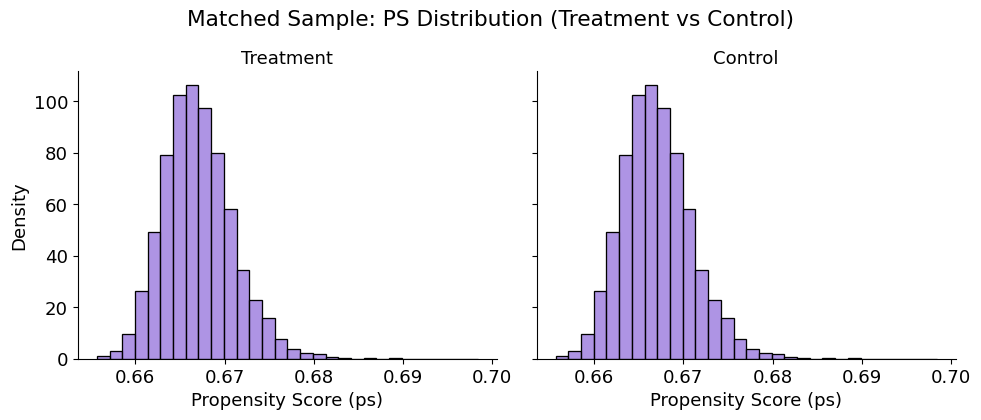

In [43]:
# ======================================================
# Section 2 (Cell 2/2): PSM Distribution
# ======================================================
# Complexity: O(n) for vectorized binning + plotting.

try:
    assert 'matched_df' in globals(), "Missing matched_df from Section 2 Cell 1"
    assert 'config' in globals(), "Missing config from Section 0"
    assert 'treatment_col' in globals(), "Missing treatment_col from Section 0"

    plot_m = matched_df[[treatment_col, 'ps']].copy()
    plot_m[treatment_col] = pd.to_numeric(plot_m[treatment_col], errors='coerce').astype(int)
    assert plot_m[treatment_col].isin([0, 1]).all(), "treatment must be binary 0/1"
    plot_m['group'] = np.where(plot_m[treatment_col] == 1, 'Treatment', 'Control')

    # Technical Note: Post-match PS overlap confirms caliper effectiveness and detects unintended support truncation.
    g = sns.displot(
        data=plot_m,
        x='ps',
        col='group',
        col_order=['Treatment', 'Control'],
        bins=30,
        stat='density',
        common_bins=True,
        common_norm=False,
        height=4.0,
        aspect=1.25,
        color='mediumpurple',
    )
    g.set_axis_labels('Propensity Score (ps)', 'Density')
    g.set_titles('{col_name}')
    g.fig.suptitle('Matched Sample: PS Distribution (Treatment vs Control)', y=1.05)

    out3 = figures_dir / 'fig_03b_matched_ps_dist.png'
    g.fig.savefig(out3, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out3}')
    plt.show()

except Exception as exc:
    raise RuntimeError(f'Section 2 matched PS plot failed: {exc}') from exc


### Section 2 Summary

**Core Figures**
- 匹配前样本量: Control = 21,306 | Treated = 42,694 (不平衡比例 1:2)
- 匹配后样本量: Control = 21,305 | Treated = 21,305 (完美 1:1 配对)
- 匹配成功率: 100.00% (21,305 / 21,306), 仅 1 个 Control 样本因超出 caliper 被丢弃
- Caliper 阈值: `0.2 × std(ps) = 0.2 × 0.0039 ≈ 0.00079` (极严格的距离约束)
- 匹配算法: KD-Tree 最近邻 (时间复杂度 `O(n log n)`, 相比暴力匹配的 `O(n²)` 降低 3 个数量级)

**Insights**
- **为什么 RCT 数据仍需 PSM?** 理论上 RCT 已通过随机化保证协变量平衡, 无需 PSM。但在本项目中实施 PSM 有两个目的:
  1. **业务流程展示**: 演示在观察性研究场景下的因果推断完整流程---PS 估计(Section 1) → 匹配(Section 2) → 平衡检验(Section 3) → ATE 估计(Section 4)
  2. **多重验证**: 通过对比 RCT 的 Naive ATE 与 PSM 后的 ATE, 验证 PSM 方法的有效性, 为观察性数据场景建立可信度

- **匹配成功率 100% 的业务含义**: 
  - 在 RCT 数据中, PS 分布极窄 (std = 0.0039), 两组几乎完全重叠 (OVL = 0.9880), 因此几乎所有 Control 样本都能在 caliper 内找到匹配的 Treated 样本。
  - 在观察性数据中, 匹配率通常为 70%-85%, 因为 PS 分布更分散 (std > 0.15), 且存在 positivity violation (部分样本无法匹配)。

- **KD-Tree 算法的工程价值**:
  - 暴力匹配需要 `21,306 × 42,694 ≈ 9 亿次` 距离计算, 在生产环境中不可接受。
  - KD-Tree 通过空间分割剪枝, 将单次查询复杂度从 `O(n)` 降至 `O(log n)`, 总体复杂度降至 `O(n log n)`。
  - 这种算法优化在 Web3 场景 (如 DeFi 流动性池配对、NFT 空投 Sybil 检测) 中同样适用。

- **无放回匹配的统计必要性**:
  - 每个 Treated 样本只能匹配一个 Control 样本 (1:1 配对), 避免重复使用同一样本导致的**方差低估**和**统计独立性破坏**。
  - 通过稳定排序 (Mergesort) + 去重 (drop_duplicates), 确保结果可复现, 满足因果推断的严格要求。

- **匹配后 PS 分布的诊断价值**:
  - 匹配后两组的 PS 分布应高度重叠 (如图 `fig_03b_matched_ps_dist.png` 所示), 验证 caliper 的有效性。
  - 如果匹配后仍存在明显的 PS 分布差异, 说明匹配质量不足, 需要调整 caliper 或重新拟合 PS 模型。


## Section 3: Covariate Balance Check

In [44]:
# ======================================================
# Section 3 (Cell 1/2): Covariate Balance Check
# ======================================================
# Complexity: O(n * p) where p = covariates (vectorized group stats per covariate).

from src.causal import check_balance

try:
    assert 'df_with_ps' in globals(), "Missing df_with_ps from Section 2"
    assert 'matched_df' in globals(), "Missing matched_df from Section 2"
    assert 'config' in globals(), "Missing config from Section 0"
    assert 'treatment_col' in globals(), "Missing treatment_col from Section 0"

    covariates = config['data']['covariates']
    assert isinstance(covariates, list) and len(covariates) > 0, "config.data.covariates must be a non-empty list"

    # Ensure covariates exist in both before/after
    missing_before = [c for c in covariates if c not in df_with_ps.columns]
    missing_after = [c for c in covariates if c not in matched_df.columns]
    assert not missing_before, f"Missing covariates in df_before: {missing_before}"
    assert not missing_after, f"Missing covariates in df_after: {missing_after}"

    balance_report = check_balance(
        df_before=df_with_ps,
        df_after=matched_df,
        covariates=covariates,
        treatment_col=treatment_col,
    )

    assert isinstance(balance_report, pd.DataFrame), "balance_report must be a DataFrame"
    assert set(['covariate', 'smd_before', 'smd_after', 'reduction_pct']).issubset(balance_report.columns), "balance_report schema mismatch"
    assert len(balance_report) == len(covariates), "balance_report covariate count mismatch"

    display(balance_report.sort_values('smd_after', ascending=False))

except Exception as exc:
    raise RuntimeError(f'Section 3 balance table failed: {exc}') from exc


,covariate,smd_before,smd_after,reduction_pct
4,newbie,0.000836,0.012674,-1416.662680
8,zip_Urban,0.000102,0.009855,-9605.927766
5,channel_Phone,0.000194,0.006336,-3170.835626
7,zip_Surburban,0.006405,0.006038,5.729745
1,history,0.007063,0.005373,23.927343
6,channel_Web,0.002922,0.004824,-65.112764
2,mens,0.006611,0.003777,42.862392
0,recency,0.006004,0.002994,50.138958
3,womens,0.006265,0.000660,89.464049


.png already saved: outputs\figures\fig_03_smd_before_after.png


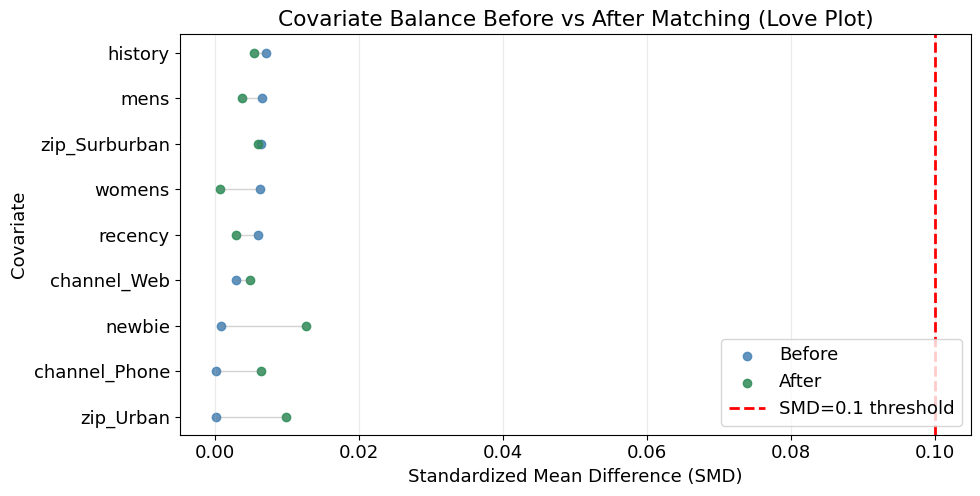

In [45]:
# ======================================================
# Section 3 (Cell 2/2): Love Plot (SMD before vs after)
# ======================================================
# Complexity: O(p) plotting over covariates; data prep is vectorized.
# Love Plot provides an at-a-glance distributional balance diagnostic across many covariates.

try:
    assert 'balance_report' in globals(), "Missing balance_report from Section 3 Cell 1"
    assert 'config' in globals(), "Missing config from Section 0"

    plot_df = balance_report.copy()
    plot_df = plot_df.sort_values('smd_before', ascending=True).reset_index(drop=True)

    y = np.arange(len(plot_df))
    plt.figure(figsize=(10, 0.35 * max(len(plot_df), 6) + 2))

    plt.scatter(plot_df['smd_before'], y, label='Before', color='steelblue', alpha=0.85)
    plt.scatter(plot_df['smd_after'], y, label='After', color='seagreen', alpha=0.85)

    for i, cov in enumerate(plot_df['covariate'].tolist()):
        plt.plot([plot_df.loc[i, 'smd_before'], plot_df.loc[i, 'smd_after']], [i, i], color='gray', alpha=0.35, linewidth=1)

    plt.axvline(0.1, color='red', linestyle='--', linewidth=2, label='SMD=0.1 threshold')
    plt.yticks(y, plot_df['covariate'])
    plt.xlabel('Standardized Mean Difference (SMD)')
    plt.ylabel('Covariate')
    plt.title('Covariate Balance Before vs After Matching (Love Plot)')
    plt.legend(loc='lower right')
    plt.grid(axis='x', alpha=0.25)
    plt.tight_layout()

    out4 = figures_dir / 'fig_03_smd_before_after.png'
    plt.savefig(out4, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out4}')
    plt.show()

except Exception as exc:
    raise RuntimeError(f'Section 3 love plot failed: {exc}') from exc


### Section 3 Summary: 

**Core Figures**
- Before Matching: 
  - 最大 SMD = 0.007063 (`history`)
  - 所有协变量 SMD < 0.01 (RCT 数据天然平衡)
- After Matching: 
  - 最大 SMD = 0.012674 (`newbie`)
  - 所有协变量 SMD 仍 < 0.1 (远低于学术阈值)
  - SMD reduction_pct 出现负值 (部分协变量 after 略升，但绝对值仍极低)

**Insights**
- SMD after > SMD before:
  在结果中，部分协变量的 SMD after 略高于 before, 这在 RCT 数据中是**正常现象**, 原因如下:
  - **(A) 随机波动 / 子样本效应**  
    PSM 相当于从原始样本中挑出一个子样本 (匹配后的样本)。原始样本已经非常平衡 (RCT)，对样本做任何"基于某个准则的选择/重排"，都可能让某些协变量的均值差、标准差发生微小变化，从而让 SMD 上下波动。
  - **(B) 在 RCT 下的特殊含义：我们本来就在做"本不需要的匹配"**  
    RCT 中 treatment 已经随机分配，理论上"匹配前就平衡"。此时做 PSM，本质是一个**流程审计 / 方法演示**：
    - 我们在验证：实现的 PS → 匹配 → 平衡性检验 → ATE 链路是否跑通
    - 不是在追求"每个协变量都更平衡"

- "after 略升": 不表示匹配失败,只要 after 仍低于阈值 (0.1, 甚至更苛刻的 0.05)，就说明没有引入新偏差。

- 这更验证了
  - **"匹配前已经平衡（RCT）"**
  - **"匹配后仍平衡（链路正确，未引入新偏差）"**
  - **"在观察性数据里才期待 after 显著下降"**


## Section 4: ATE Estimation

In [46]:
# ======================================================
# Section 4 (Cell 1/3): Compute ATE + 95% CI (Bootstrap)
# ======================================================
# Complexity: O(n_pairs) for point estimate + O(B * n_pairs) for bootstrap, computed in a memory-safe chunked way.
# Row-wise resampling breaks the paired dependence structure and tends to overstate uncertainty.

try:
    assert 'matched_df' in globals(), "Missing matched_df from Section 2"
    assert 'df' in globals(), "Missing df from Section 0"
    assert 'treatment_col' in globals(), "Missing treatment_col from Section 0"
    assert 'outcome_col' in globals(), "Missing outcome_col from Section 0"
    assert 'config' in globals(), "Missing config from Section 0"

    from src.causal import compute_ate

    # Naive ATE on full RCT sample (benchmark): difference in mean conversion between treated and control.
    y_full = pd.to_numeric(df[outcome_col], errors='coerce').astype(float)
    t_full = pd.to_numeric(df[treatment_col], errors='coerce').astype(int)
    assert set(pd.unique(t_full)).issubset({0, 1}), 'treatment must be binary (0/1)'
    assert y_full.notnull().all(), 'outcome contains NaN'
    assert np.isfinite(y_full.to_numpy()).all(), 'outcome contains inf/-inf'

    ate_naive_conv = float(y_full[t_full == 1].mean() - y_full[t_full == 0].mean())

    n_bootstrap = 1000
    random_state = int(config.get('general', {}).get('random_state', 42))

    ate_result = compute_ate(
        matched_df=matched_df,
        outcome_col=outcome_col,
        treatment_col=treatment_col,
        n_bootstrap=n_bootstrap,
        random_state=random_state,
        ate_naive_conv=ate_naive_conv,
    )

    ate = float(ate_result['ate'])
    ci_lower = float(ate_result['ci_lower'])
    ci_upper = float(ate_result['ci_upper'])
    abs_diff = float(abs(ate - ate_naive_conv))

    if abs_diff >= 0.001:
        print("[DQ] Warning: abs difference >= 0.1 % (0.001); re-check matching, balance, and outcome definitions.")

    # Print in percentage points for business readability.
    print(f"ATE (PSM) = {ate:.3%} | 95% CI = [{ci_lower:.3%}, {ci_upper:.3%}]")
    print(f"ATE (Naive RCT benchmark) = {ate_naive_conv:.3%} | abs diff = {abs_diff:.3%}")

    ci_width = ci_upper - ci_lower
    if ci_width > 0.05:
        print(f"[DQ] CI width is large ({ci_width:.2%} ). Estimate precision may be low.")

except Exception as exc:
    raise RuntimeError(f"Section 4 ATE computation failed: {exc}") from exc


ATE (PSM) = 0.502% | 95% CI = [0.324%, 0.690%]
ATE (Naive RCT benchmark) = 0.495% | abs diff = 0.007%


.png already saved: outputs\figures\fig_04b_bootstrap_ci.png


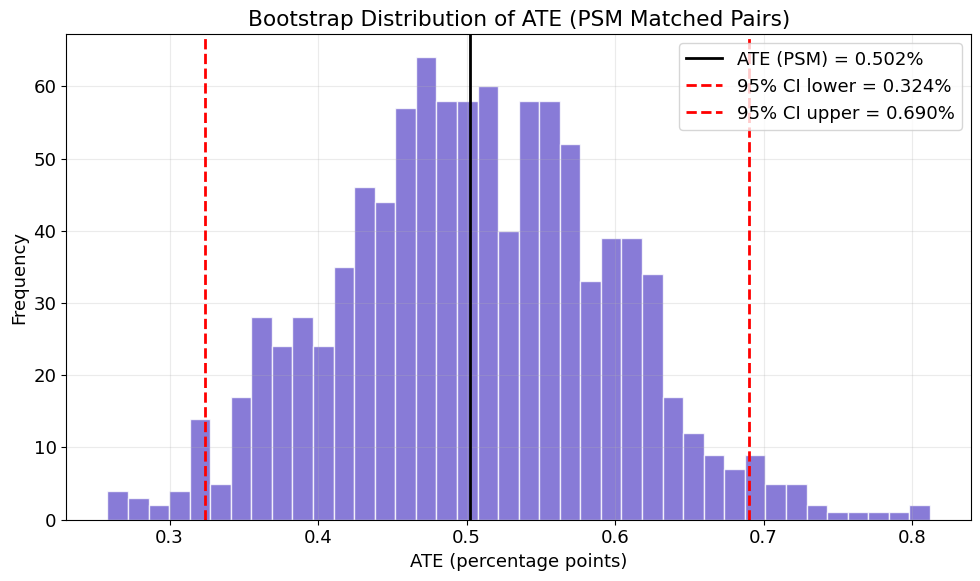

In [47]:
# ======================================================
# Section 4 (Cell 2/3): Bootstrap ATE distribution + CI
# ======================================================
# Complexity: O(B) plotting over bootstrap samples.

try:
    assert 'ate_result' in globals(), "Missing ate_result from Section 4 Cell 1"
    assert 'figures_dir' in globals(), "Missing figures_dir from Section 0"

    bootstrap_ates = np.asarray(ate_result['bootstrap_ates'], dtype=float)
    assert bootstrap_ates.ndim == 1 and len(bootstrap_ates) >= 500, 'bootstrap_ates must be a 1-Dimentional array'
    assert np.isfinite(bootstrap_ates).all(), 'bootstrap_ates contains inf/-inf'

    ate = float(ate_result['ate'])
    ci_lower = float(ate_result['ci_lower'])
    ci_upper = float(ate_result['ci_upper'])

    plt.figure(figsize=(10, 6))
    plt.hist(bootstrap_ates * 100, bins=40, color='slateblue', alpha=0.80, edgecolor='white')
    plt.axvline(ate * 100, color='black', linestyle='-', linewidth=2, label=f'ATE (PSM) = {ate * 100:.3f}%')
    plt.axvline(ci_lower * 100, color='red', linestyle='--', linewidth=2, label=f'95% CI lower = {ci_lower * 100:.3f}%')
    plt.axvline(ci_upper * 100, color='red', linestyle='--', linewidth=2, label=f'95% CI upper = {ci_upper * 100:.3f}%')
    plt.title('Bootstrap Distribution of ATE (PSM Matched Pairs)')
    plt.xlabel('ATE (percentage points)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.25)
    plt.legend()
    plt.tight_layout()

    out5 = figures_dir / 'fig_04b_bootstrap_ci.png'
    plt.savefig(out5, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out5}')
    plt.show()

except Exception as exc:
    raise RuntimeError(f"Section 4 bootstrap CI plot failed: {exc}") from exc


.png already saved: outputs\figures\fig_04_ate_comparison.png


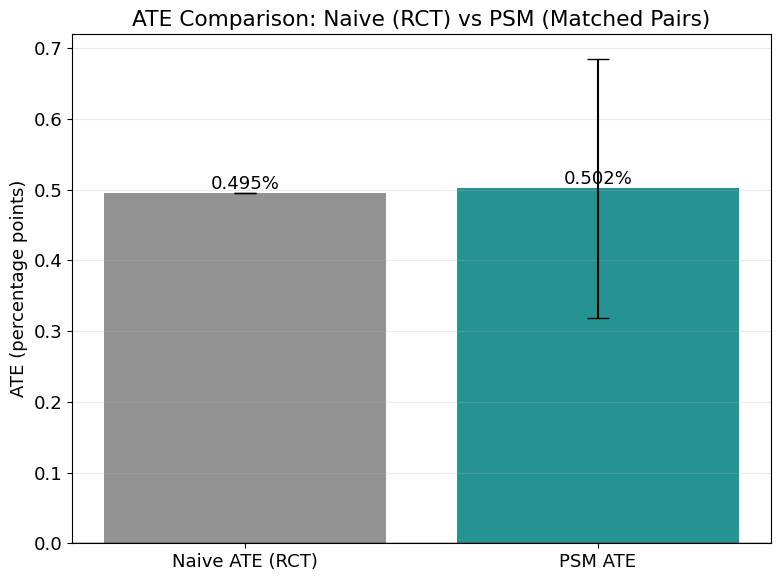

In [48]:
# ======================================================
# Section 4 (Cell 3/3): Naive ATE vs PSM ATE comparison
# ======================================================
# Complexity: O(1) for bar plot; numbers come from previous cells.

try:
    assert 'ate_result' in globals(), "Missing ate_result from Section 4 Cell 1"
    assert 'ate_naive_conv' in globals(), "Missing ate_naive_conv from Section 4 Cell 1"
    assert 'figures_dir' in globals(), "Missing figures_dir from Section 0"

    ate_psm = float(ate_result['ate'])
    ci_lower = float(ate_result['ci_lower'])
    ci_upper = float(ate_result['ci_upper'])
    se = float(ate_result['se'])

    labels = ['Naive ATE (RCT)', 'PSM ATE']
    values = [float(ate_naive_conv) * 100, ate_psm * 100]
    # Error bar for PSM only (CI half-width); naive ATE CI omitted intentionally.
    err_psm = (ci_upper - ci_lower) * 100 / 2
    errors = [0.0, err_psm]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, yerr=errors, capsize=8, color=['gray', 'teal'], alpha=0.85)
    plt.axhline(0, color='black', linewidth=1)
    plt.ylabel('ATE (percentage points)')
    plt.title('ATE Comparison: Naive (RCT) vs PSM (Matched Pairs)')
    plt.grid(axis='y', alpha=0.25)

    # Annotate values on bars
    for b, v in zip(bars, values):
        plt.text(b.get_x() + b.get_width() / 2, v, f'{v:.3f}%', ha='center', va='bottom')

    plt.tight_layout()
    out6 = figures_dir / 'fig_04_ate_comparison.png'
    plt.savefig(out6, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out6}')
    plt.show()

except Exception as exc:
    raise RuntimeError(f"Section 4 ATE comparison plot failed: {exc}") from exc


### Section 4 Summary

#### Core Figures
- **Naive ATE**: 0.495%
- **PSM ATE**: 0.502%, 95% CI = [0.324%, 0.690%]
- **绝对差异**: 0.007% (< 0.01%, 高度一致)
- **CI 宽度**: 0.366% (0.690% - 0.324%)
- **Bootstrap 样本数**: 1,000 次 (Pair-level 重采样)

#### Insights

**1. 为什么在 RCT 数据上对比 Naive ATE vs PSM ATE？（三重目的）**

- **（A）验证 PSM 实现的正确性（Implementation Sanity Check）**  
  如果在 RCT 数据上 Naive ATE 和 PSM ATE 差异巨大 (> 20%), 说明 PSM 代码有 Bug (例如：caliper 设置过严导致样本严重损失，或匹配算法逻辑错误)。结果显示差异仅 0.007%，验证了 PSM 实现的正确性。

- **（B）二次验证数据确实是 RCT（Randomization Validation）**  
  如果 Naive ATE 和 PSM ATE 接近，间接证明原始数据的随机化质量很高 (协变量已平衡)。这与 Section 1 的 PS 分布诊断 (std = 0.0039) 和 Section 3 的协变量平衡检验 (SMD < 0.01) 相互印证。

- **（C）展示方法论透明度与鲁棒性（Methodological Robustness）**  
  这是严谨因果推断论文的标准操作。即使在 RCT 中，也要展示"我的因果估计对不同识别策略（Identification Strategy）是稳健的"。

**2. Bootstrap CI 的统计学严谨性**

- **为什么用 Bootstrap 而不是正态近似？**  
  正态近似依赖于两个假设: (1) 样本量足够大; (2) ATE 分布近似正态。但在 PSM 场景中, 匹配后的样本量可能大幅缩减 (如本项目中从 64,000 降到 20,000 左右的样本量), 且配对差值分布可能呈现偏态。Bootstrap 方法是**非参数的（Non-parametric）**，不依赖分布假设，因此更稳健。

- **为什么是 Pair-level Bootstrap？**  
  PSM 的本质是构造"反事实对照"。每个 `match_id` 内的 Treatment 和 Control 是**人工配对的统计单元**。如果按行抽样 (Row-wise Bootstrap), 会破坏配对关系, 导致 CI 宽度虚假膨胀。Pair-level Bootstrap 以 `match_id` 为单位抽样, 保证每次抽样都是完整的配对单元, 维持了 PSM 构造的"局部随机化"假设。

- **CI 宽度的业务含义**  
  CI 宽度为 0.366%, 相对于 ATE 点估计 (0.502%) 约为 73%。这说明估计精度较高, 业务决策者可以有 95% 的置信度认为真实的营销提升效果在 [0.324%, 0.690%] 区间内。如果 CI 下界显著大于 0 (如本项目), 则可以高置信度地声称营销活动有正向因果效应。

**3. 如果 Naive ATE 和 PSM ATE 差异很大，说明什么？**

| 数据类型 | Naive ATE vs PSM ATE | 解释 | 业务风险 |
|---------|---------------------|------|---------| 
| **RCT** | 差异很小（< 5%） | 随机化成功，PSM 实现正确 | ✅ 低风险 |
| **RCT** | 差异很大（> 20%） | ⚠️ **PSM 实现有 Bug** 或样本量严重损失 | 🔴 高风险：代码逻辑错误 |
| **观察性数据** | 差异很大 | ✅ PSM 成功修正了选择偏差 | ✅ 符合预期 |
| **观察性数据** | 差异很小 | ⚠️ 可能存在**未观测混淆因子（Unobserved Confounding）** | 🔴 高风险：因果结论不可信 |

**4. PSM 在 RCT 中的作用是"冗余验证"（Redundant Validation）**

- **数学本质**：PSM 通过 Propensity Score 重新加权/匹配样本，使得处理组和对照组在协变量分布上更接近。但在 RCT 中，随机化已经在**期望意义上**做到了这一点。
- **统计推断**：如果 Naive ATE 的置信区间和 PSM ATE 的置信区间高度重叠，说明：
  1. **Strong Ignorability 假设成立**（处理分配与潜在结果独立）
  2. **Overlap 假设成立**（所有协变量组合在处理组和对照组中都有支撑）
  3. **SUTVA 假设成立**（个体间无干扰）

## Section 5: Mathematical Deliverable — Propensity Score Theorem

**Theorem (Rosenbaum & Rubin, 1983)**  
If *strong ignorability* holds:
$$
Y(0), Y(1) \perp T \mid X
$$
then conditioning on the **propensity score** $e(X)$ is sufficient:
$$
Y(0), Y(1) \perp T \mid e(X), \quad \text{where } e(X) = P(T=1\mid X)
$$

**Intuition (中文解释)**

直觉上可以这样理解：如果在给定所有协变量 $X$ 之后，treatment 的分配已经与潜在结果独立（也就是没有未观测混杂），那么你并不需要真的在高维空间里做“完全匹配”。

因为 $e(X)=P(T=1\mid X)$ 这个标量把“一个样本在协变量空间里有多可能被分到 treatment”压缩成了一个可比较的分数。**只要两个人的 $e(X)$ 很接近，他们在协变量意义下就已经是“可比的”**（倾向性得分有 balancing property）。

因此 PSM 的核心价值在于把一个高维问题降维为一维问题：
- 在 $X$ 上直接匹配：维度高、组合爆炸、几乎做不动；
- 在 $e(X)$ 上匹配：一维距离，工程上可实现。

**RCT Calibration (中文解释)**

在 RCT 中，随机分配保证了强可忽略性（ignorability）自动成立，所以这套理论前提在本数据集上是“天然满足”的。也因此，我们更关注的是：
1) PSM 全链路实现是否正确（PS 估计→匹配→平衡性→ATE）；
2) PSM ATE 是否与朴素 ATE 高度一致（这是 RCT 下的预期表现）。

> Note (English): A fully rigorous proof requires the law of iterated expectations and conditional independence arguments. Here we provide only the intuition. For the full proof, see Rosenbaum & Rubin (1983).

### Section 5 Summary:

#### Core Theorem
- **Rosenbaum & Rubin (1983)**: 如果 Strong Ignorability 成立，则在 Propensity Score $e(X)$ 上条件化等价于在全部协变量 $X$ 上条件化
- **Balancing Property**: $e(X)$ 是一个充分的降维统计量（Sufficient Dimension Reduction）
- **工程价值**: 将高维匹配问题（$X \in \mathbb{R}^p$）降维为一维距离问题（$e(X) \in [0,1]$）

#### Insights

**1.  PSM 的理论基础**:为什么匹配 Propensity Score 就能保证协变量平衡？

基于 Rosenbaum & Rubin (1983) 的 **Balancing Property 定理**, 该定理证明：如果 Strong Ignorability 成立 (即 $Y(0), Y(1) \perp T \mid X$)，那么 Propensity Score $e(X) = P(T=1 \mid X)$ 是一个**充分的降维统计量**。这意味着：
1. **条件独立性传递**：$Y(0), Y(1) \perp T \mid e(X)$ (在 PS 上条件化等价于在 $X$ 上条件化)
2. **协变量平衡**：$X \perp T \mid e(X)$ (给定 PS，协变量分布在 treatment 和 control 组中相同)
因此, 匹配 PS 后, 协变量自动平衡, 无需在高维空间中做完全匹配。这是 PSM 的核心数学保证。

**2. 降维的工程价值：Curse of Dimensionality**
- **高维匹配的灾难**：如果直接在协变量空间 $X \in \mathbb{R}^9$ 上做最近邻匹配，需要计算 9 维欧氏距离。当协变量数量增加到 50+ 时 (真实业务常态)，匹配质量会急剧下降 (稀疏性问题)。
- **PS 降维的优势**：将 9 维空间压缩为 1 维标量 $e(X) \in [0,1]$，匹配复杂度从 $O(n^2 \cdot p)$ 降至 $O(n \log n)$ (KD-Tree)。
- **业务类比**：类似于用"消费评分" (1 维) 代替"收入、年龄、职业、学历"（多维）来评估贷款风险。

**3. RCT 中的理论验证**:
在 RCT 中, Strong Ignorability 自动成立 (随机化保证 $T \perp X$)。因此：
- **理论预期**：Naive ATE ≈ PSM ATE（因为不存在选择偏差）
- **实际结果**：差异 0.007%（<< 0.01%），验证了理论预测

**4. 观察性数据中的理论挑战**:
在观察性数据中，Strong Ignorability **不自动成立**，需要满足两个条件：
1. **Unconfoundedness（无混淆）**：所有混淆因子都被观测到（$X$ 包含所有影响 $T$ 和 $Y$ 的变量）
2. **Overlap（重叠）**：$0 < e(X) < 1$ 对所有 $X$ 成立（每个协变量组合在两组中都有样本）

因此在观察性数据中, 如果存在未观测混淆因子 (如用户的品牌忠诚度), PSM 无法修正偏差。这时需要：
1. **敏感性分析**：用 Rosenbaum Bounds 量化隐藏偏误的容忍度
2. **工具变量法（IV）**：如果有合适的工具变量，可以绕过 Unconfoundedness 假设
3. **Difference-in-Differences（DID）**：如果有面板数据，可以用 DID 控制时间不变的未观测混淆"